# Looking at Baltimore City Government "Customer Churn" 

__Customer Churn__ is the percentage of a company's customers lost in a given period, which is calculated:

```
(# of customers lost in time period / # of total customers at the beginning of time period)*100%
```

This metric is most commonly used for businesses that operate on a subscription basis as a metric to assess how their customer base is shrinking or growing over time. Customer churn is important to track because: 
 - A positive customer churn rate means the business is losing customers and related revenue
 - It's expensive to get new customers (spend more money on advertising, PR, etc.)
 - If the business's success depends on a network effect (e.g. social media), this could result in damaged reputation or worse service/product for customers
 - The customer base has less company loyalty
 - There could be more competitors in the industry that may provide better or better targeted products
 - Consumer needs and wants could be shifting, which may indicate that the business might want to pivot or expand product/service offerings
 
Another way we can think of customer churn is by looking at "customers" as companys' employee bases and calculating the "customer churn" as the employee turnover rate. Understanding employee turnover rate is important for an organization for all of the same reasons stated above--it's expensive to recruit, onboard, and train new employees! Additionally, maintaining a good/strong company culture is incredibly important in employees' job satisfaction, so high turnover rates may also contribute to lower job performance and employee satisfaction.  

Here, we'll look at Baltimore City Government employee salary data from fiscal years 2011-2019 to analyze employee turnover rates for city government as a whole and by department to see if there are any departments that might strongly contribute to a potential citywide turnover rate. The raw data is availble on [Baltimore City Open Data](https://data.baltimorecity.gov/browse?category=City+Government), and the aggregated city salary data is created from [this python notebook](https://github.com/jhu-business-analytics/multiple-linear-regression-excel-example/blob/master/2019-11-13-melanieshimano-baltimore-salary-2011-2018-combined.ipynb), and available in [this repository](https://github.com/jhu-business-analytics/customer-churn-example).

## import libraries 

In [1]:
import pandas as pd # for data analysis
import numpy as np # for data analysis
import plotly.express as px # to visualize data

## import data 

In [2]:
# baltimore city salary data aggregated 

df = pd.read_csv("total_bmore_city_salaries_2011_2019.csv")

In [3]:
# preview data
df.head()

employee_name                       jobtitle  deptid  \
0    Aaron,Patricia G  Facilities/Office Services II  A03031   
1       Aaron,Petra L     ASSISTANT STATE'S ATTORNEY  A29005   
2  Abaineh,Yohannes T                 EPIDEMIOLOGIST  A65026   
3  Abdal-Rahim,Naim A                EMT Firefighter  A64063   
4      Abdi,Ezekiel W                 POLICE OFFICER  A99398   

                 dept_name     hire_dt  annual_rt     gross  fiscal_year  \
0       OED-Employment Dev  1979-10-24    50845.0  45505.94         2011   
1  States Attorneys Office  2006-09-25    56595.0  51588.89         2011   
2   HLTH-Health Department  2009-07-23    56500.0  50633.26         2011   
3    Fire Academy Recruits  2011-03-30    33476.0   3888.95         2011   
4        Police Department  2007-06-14    50919.0  51421.73         2011   

   years_in_gov  
0     31.683060  
1      4.761220  
2      1.935700  
3      0.251887  
4      4.043889

## clean/reorganize data 

First, let's look at the general trend of employees in Baltimore City government over all of the available fiscal years.

In [4]:
# eventually use plotly express to make a line graph of number of Baltimore City employee trends
# but first, aggregate the data to count the number of employees in each fiscal year

df_all_emp = df.groupby("fiscal_year")["employee_name"].agg(["count"]).reset_index()

In [5]:
# look at aggregated dataset
df_all_emp

fiscal_year  count
0         2011  14454
1         2012  16049
2         2013  19137
3         2014  18981
4         2015  14017
5         2016  13818
6         2017  13483
7         2018  13683
8         2019  13811

In [6]:
# make line graph with plotly
line_all_emp = px.line(df_all_emp,
                      x = "fiscal_year",
                      y = "count",
                      title = "Number of Baltimore City Government Employees Across Fiscal Years 2011-2019")

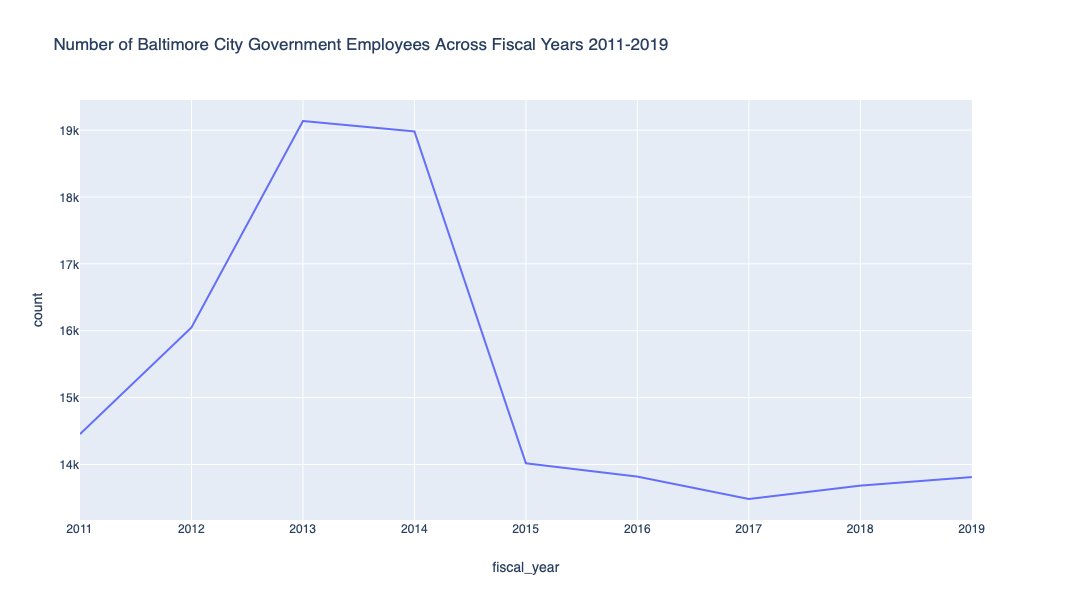

In [7]:
line_all_emp

In [8]:
# export this as an html plot
line_all_emp.write_html("all_bmore_employees_2011_19.html")

Now, let's separate these trends out by department to see if any department(s) contribute more heavily to employment trends. We see a sharp dip in employee numbers from 2014-2015 (about 5,000 (!)) less employees in a single fiscal year. This could be due to organizational change (e.g. departments were removed as city government departments, full-time employees were moved to contract positions, etc.) or due to leadership or environmental changes. 

In [9]:
# first, we need to clean the data
# look at all unique department names:
df["dept_name"].unique().tolist()

['OED-Employment Dev',
 'States Attorneys Office',
 'HLTH-Health Department',
 'Fire Academy Recruits',
 'Police Department',
 'Liquor License Board',
 'Enoch Pratt Free Library',
 'Housing & Community Dev',
 'TRANS-Highways',
 'TRANS-Traffic',
 'DPW-Solid Waste',
 'Fire Department',
 'Circuit Court',
 'DPW-Water & Waste Water',
 'FIN-Collections',
 'M-R Convention Center',
 'TRANS-Crossing Guards',
 "Sheriff's Office",
 'FIN-Purchasing',
 'COMP-Communication Services',
 'COMP-Audits',
 'R&P-Parks',
 'Youth Cust',
 'R&P-Recreation',
 'General Services',
 'R&P-Administration',
 'Legislative Reference',
 'HR-Human Resources',
 'FIN-Admin & Budgets',
 'M-R Info Technology',
 'TRANS-Towing',
 'COMP-Real Estate',
 'Youth Temp Adult',
 'Law Department',
 'City Council',
 'FPR Admin',
 'DPW-Administration',
 'Elections',
 'Community Relations',
 'FIN-Acct & Payroll',
 'Planning Department',
 "COMP-Comptroller's Office",
 'Mayors Office',
 'ERS/EOS Admin',
 'M-R Environmental Cntrl',
 'Council

In [10]:
# some of these names are not grouped together because there extra spaces in the title 
# or because there are different sub-categories of departments

# first, we'll strip the department names to remove unnecessary spaces
df["dept_name"] = df["dept_name"].str.strip()

In [11]:
# now, let's combine the subcategories of the departments so that we get a more hollistic view of departmental changes and size
# we see that ["HLTH", "COMP", "TRANS", "FIN", "DPW", "R&P"] all have subcategories,
# <<health dept, comptroller dept, transportation dept, finance dept, dept of public works, rec & parks>>
# so we'll write a function to keep only the capital abreviation of the department name

# items we want to group together
subcategories = ["HLTH", "COMP", "TRANS", "FIN", "DPW", "R&P"]

# join the list with a pipe to indicate an "or" when we write our action later
joined_sub = "|".join(subcategories) 

In [12]:
# our joined list looks this
# and reads as "HLTH OR COMP OR TRANS OR FIN OR DPW OR R&P"
joined_sub

'HLTH|COMP|TRANS|FIN|DPW|R&P'

In [13]:
# "redefine" department name using np.where, which is similar to an Excel IF statement
# format: np.where(condition, value if true, value if false)

df["dept_name"] = np.where(df["dept_name"].str.contains(joined_sub), # condition is if the value in "dept_name" is in the list
                           df["dept_name"].str.split("-", expand = True)[0], # if it's in the list, keep only the CAPS letters
                          df["dept_name"]) #if it's false, keep the original dept name

In [14]:
# preview our revised dataset
# notice that HLTH is now only HLTH
df.head(10)

employee_name                       jobtitle  deptid  \
0       Aaron,Patricia G  Facilities/Office Services II  A03031   
1          Aaron,Petra L     ASSISTANT STATE'S ATTORNEY  A29005   
2     Abaineh,Yohannes T                 EPIDEMIOLOGIST  A65026   
3     Abdal-Rahim,Naim A                EMT Firefighter  A64063   
4         Abdi,Ezekiel W                 POLICE OFFICER  A99398   
5       Abdul Hamid,Umar      LIQUOR BOARD INSPECTOR II  A09001   
6  Abdul Saboor,Jamillah                 OFFICE ASST II  A75067   
7  Abdul-Jabbar,Bushra A    SOCIAL SERVICES COORDINATOR  A65201   
8     Abdullah,Beverly A                     TYPIST III  A06004   
9     Abdullahi,Sharon M                   911 OPERATOR  A99371   

                  dept_name     hire_dt  annual_rt     gross  fiscal_year  \
0        OED-Employment Dev  1979-10-24    50845.0  45505.94         2011   
1   States Attorneys Office  2006-09-25    56595.0  51588.89         2011   
2                      HLTH  2009-07-23    56500.0  50633.26         2011   
3     Fire Academy Recruits  2011-03-30    33476.0   3888.95         2011   
4         Police Department  2007-06-14    50919.0  51421.73         2011   
5      Liquor License Board  1995-01-17    43278.0  39116.93         2011   
6  Enoch Pratt Free Library  2009-07-27    26388.0  23758.19         2011   
7                      HLTH  2008-04-14    38582.0  31096.45         2011   
8   Housing & Community Dev  1986-12-01    34453.0  31273.03         2011   
9         Police Department  2004-06-10    37677.0  36844.61         2011   

   years_in_gov  
0     31.683060  
1      4.761220  
2      1.935700  
3      0.251887  
4      4.043889  
5     16.449345  
6      1.924749  
7      3.208827  
8     24.578191  
9      7.052848

In [15]:
# we also want to fix the "Mayors Office" vs "Mayor's Office" difference
# we'll change all mayor's office to "Mayors Office"

df["dept_name"] = np.where(df["dept_name"] == "Mayor's Office", # if value equals "Mayor's Office"
                          "Mayors Office", # change to "Mayors Office"
                          df["dept_name"]) # otherwise, keep the same

In [16]:
# look at the unique departments now
df["dept_name"].unique().tolist()

['OED-Employment Dev',
 'States Attorneys Office',
 'HLTH',
 'Fire Academy Recruits',
 'Police Department',
 'Liquor License Board',
 'Enoch Pratt Free Library',
 'Housing & Community Dev',
 'TRANS',
 'DPW',
 'Fire Department',
 'Circuit Court',
 'FIN',
 'M-R Convention Center',
 "Sheriff's Office",
 'COMP',
 'R&P',
 'Youth Cust',
 'General Services',
 'Legislative Reference',
 'HR-Human Resources',
 'M-R Info Technology',
 'Youth Temp Adult',
 'Law Department',
 'City Council',
 'FPR Admin',
 'Elections',
 'Community Relations',
 'Planning Department',
 'Mayors Office',
 'ERS/EOS Admin',
 'M-R Environmental Cntrl',
 'Council Services',
 'TANF Cust',
 'War Memorial Commission',
 'HR-Test Monitor',
 'M-R Labor Commissioner',
 'Special City Services',
 'Municipal & Zoning Appeals 001',
 'Wage Commissioner',
 'M-R Cable & Comm',
 "Orphan's Court",
 'M-R Human Services',
 'Civil Rights & Wage Enforce',
 'Youth Summer',
 'OED-Participants-Youth Summer',
 'Municipal & Zoning Appeal',
 'Civil

In [17]:
# we'll export this cleaned dataset as a csv to work with later
df.to_csv("baltimore_salaries_2011_2019_agg_dept.csv", index = False)

In [18]:
# how many unique departments are there?
df["dept_name"].nunique()

51

In [19]:
# there seems to be some organizational change in 2015
# let's look at the trends of number of employees per department over the fiscal years
# first, we'll create a new aggregated dataset

df_dept_count = df.groupby(["fiscal_year", "dept_name"])["employee_name"].agg(["count"]).reset_index()

In [20]:
# preview data
df_dept_count.head(10)

fiscal_year                 dept_name  count
0         2011                      COMP     91
1         2011             Circuit Court    154
2         2011              City Council     88
3         2011       Community Relations     10
4         2011          Council Services      5
5         2011                       DPW   2356
6         2011             ERS/EOS Admin     27
7         2011                 Elections      6
8         2011  Enoch Pratt Free Library    442
9         2011                       FIN    265

In [21]:
# make a plotly chart to look at all of the departments on the same graph
line_dept = px.line(df_dept_count,
                   x= "fiscal_year",
                   y = "count", 
                   color = "dept_name",
                   title = "Number of Employees in Baltimore City Government Departments in Fiscal Years 2011-2019",
                   #range_y = [0, 200]
                   )

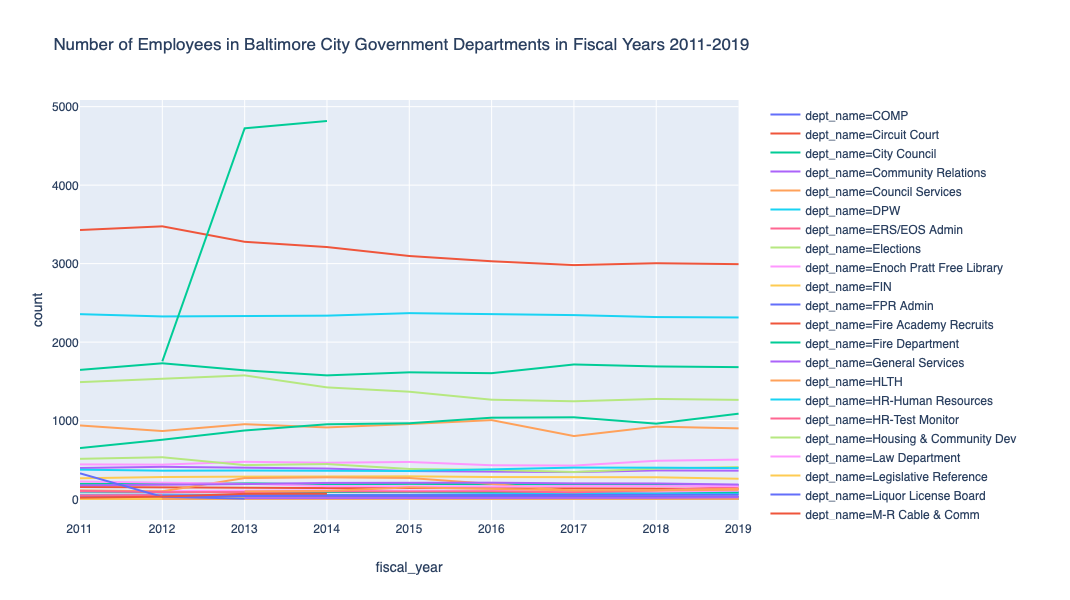

In [22]:
line_dept

In [23]:
# export the line graph separated by departments
line_dept.write_html("dept_bmore_employees_2011_19.html")

## refining data 

We see that "Youth Summer" (YouthWorks?) contributes most to the big drop in employee churn, however, since there is only data for "Youth Summer" for 2012-2014, we'll look at the aggregated employment churn and trends without "Youth Summer" to see what the total employment trends look like over the given fiscal years.

In [24]:
# redefine dataframe to remove Youth Summer department
df_no_youthworks = df[df["dept_name"] != "Youth Summer"]

In [25]:
# re-aggregate data by fiscal year
df_no_yw_agg = df_no_youthworks.groupby("fiscal_year")["employee_name"].agg(["count"]).reset_index()

In [26]:
df_no_yw_agg

fiscal_year  count
0         2011  14454
1         2012  14294
2         2013  14413
3         2014  14164
4         2015  14017
5         2016  13818
6         2017  13483
7         2018  13683
8         2019  13811

In [27]:
# plot data with plotly express

bmore_empoloyee_line = px.line(df_no_yw_agg,
                              x = "fiscal_year",
                              y = "count",
                              title = "Number of Baltimore City Government Employees in Fiscal Years 2011-2019 <br> Excluding 'Youth Summer'")

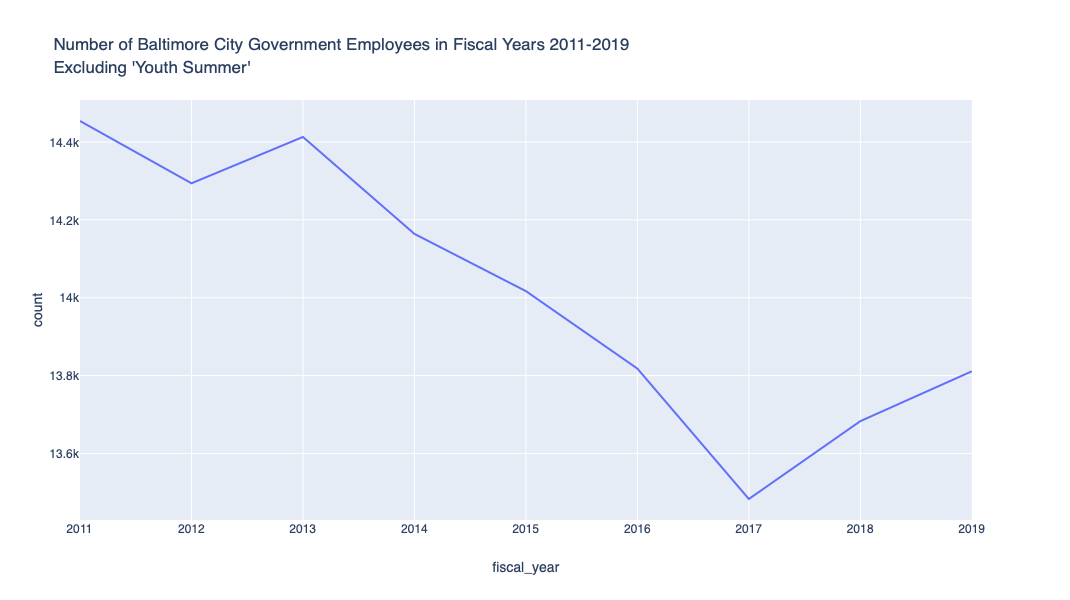

In [28]:
bmore_empoloyee_line

This now makes it look like there's consistent churn over fiscal years 2013-2017, instead of a sharp drop in employment in 2015. Let's look at total and department employee churn over this time period to get a better sense of what this means. 

In [29]:
# save this as an html
bmore_empoloyee_line.write_html("all_bmore_employees_no_youthworks_2011_19.html")

In [30]:
# look at department trends with new dataset
df_dept_count_no_yw = df_no_youthworks.groupby(["fiscal_year", "dept_name"])["employee_name"].agg(["count"]).reset_index()

In [31]:
df_dept_count_no_yw.head(10)

fiscal_year                 dept_name  count
0         2011                      COMP     91
1         2011             Circuit Court    154
2         2011              City Council     88
3         2011       Community Relations     10
4         2011          Council Services      5
5         2011                       DPW   2356
6         2011             ERS/EOS Admin     27
7         2011                 Elections      6
8         2011  Enoch Pratt Free Library    442
9         2011                       FIN    265

In [32]:
# plot data with no youthworks
# plot the churn of departments on a line graph
bmore_dept_line_no_yw = px.line(df_dept_count_no_yw, # use revised data frame
                         x = "fiscal_year", # fiscal year on the x axis
                         y = "count", # churn rate on the 
                          color = "dept_name",
                         title = "Baltimore City Employment By Department in Fiscal Years 2011-2019 <br> Excluding YouthWorks",
                          #range_y = [-20,0]
                         )

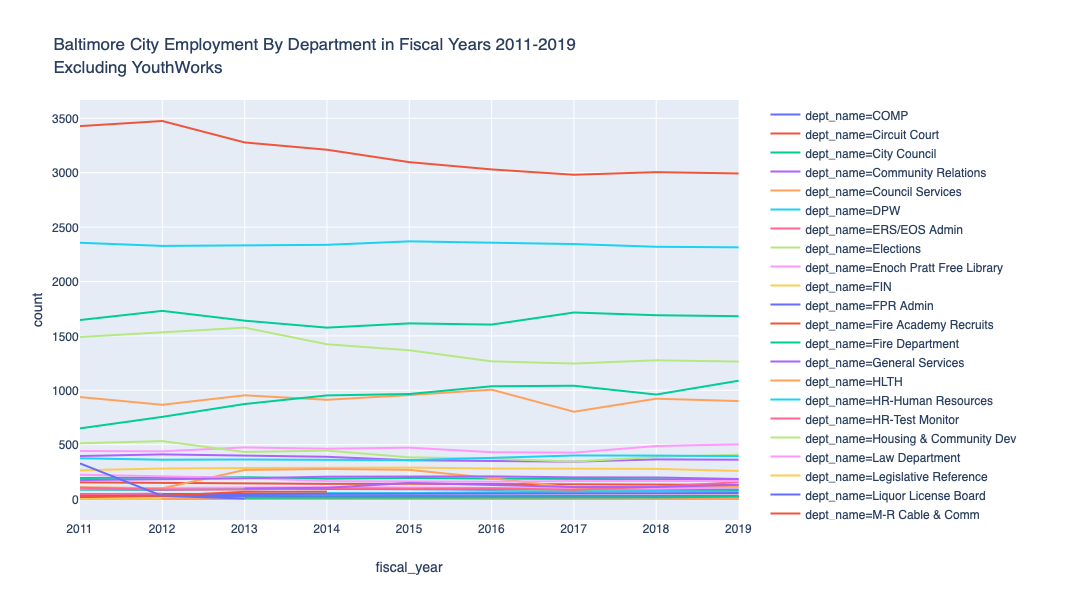

In [33]:
bmore_dept_line_no_yw

## calculating employee churn 

In [34]:
# we see that the total number of employees hasn't drastically changed for each department over each fiscal year
# but this doesn't tell us the turnover of employees in each department
# now, we'll calculate employee churn for the entire city government

# look at aggregated data
df_all_emp

fiscal_year  count
0         2011  14454
1         2012  16049
2         2013  19137
3         2014  18981
4         2015  14017
5         2016  13818
6         2017  13483
7         2018  13683
8         2019  13811

In [35]:
# create a new column that calculates the number of employees lost in that fiscal year
df_all_emp["lost"] = df_all_emp["count"].diff()*(-1)

In [36]:
df_all_emp

fiscal_year  count    lost
0         2011  14454     NaN
1         2012  16049 -1595.0
2         2013  19137 -3088.0
3         2014  18981   156.0
4         2015  14017  4964.0
5         2016  13818   199.0
6         2017  13483   335.0
7         2018  13683  -200.0
8         2019  13811  -128.0

A "negative" number of employees lost indicates that employees were gained/hired.

In [37]:
# customer churn column 
# # employees lost in fiscal year/# employees at beginning of fiscal year (e.g. negative percent change)
df_all_emp["employee_churn"] = df_all_emp["count"].pct_change()*(-1)

In [38]:
df_all_emp

fiscal_year  count    lost  employee_churn
0         2011  14454     NaN             NaN
1         2012  16049 -1595.0       -0.110350
2         2013  19137 -3088.0       -0.192411
3         2014  18981   156.0        0.008152
4         2015  14017  4964.0        0.261525
5         2016  13818   199.0        0.014197
6         2017  13483   335.0        0.024244
7         2018  13683  -200.0       -0.014833
8         2019  13811  -128.0       -0.009355

In [39]:
df_dept_count.head()

fiscal_year            dept_name  count
0         2011                 COMP     91
1         2011        Circuit Court    154
2         2011         City Council     88
3         2011  Community Relations     10
4         2011     Council Services      5

In [40]:
# sort by fiscal year and then by department name
df_dept_count = df_dept_count.sort_values (by = ["dept_name","fiscal_year"])

In [41]:
df_dept_count.head(10)

fiscal_year      dept_name  count
0           2011           COMP     91
42          2012           COMP     86
83          2013           COMP     95
124         2014           COMP     90
163         2015           COMP     91
200         2016           COMP     87
240         2017           COMP     95
277         2018           COMP     86
314         2019           COMP     87
1           2011  Circuit Court    154

In [42]:
# for each fiscal year, calculate the difference between it and the above row
df_dept_count["lost"] = np.where(df_dept_count["fiscal_year"].diff() == 1.0, # if fiscal year difference = 1.0
                                df_dept_count["count"].diff()* (-1), # calculate the number of employees lost
                                "NaN") # otherwise NaN

In [43]:
df_dept_count.head(10)

fiscal_year      dept_name  count  lost
0           2011           COMP     91   NaN
42          2012           COMP     86   5.0
83          2013           COMP     95  -9.0
124         2014           COMP     90   5.0
163         2015           COMP     91  -1.0
200         2016           COMP     87   4.0
240         2017           COMP     95  -8.0
277         2018           COMP     86   9.0
314         2019           COMP     87  -1.0
1           2011  Circuit Court    154   NaN

In [44]:
# calculate employee churn in each department for each fiscal year
df_dept_count["churn"] = df_dept_count["count"].pct_change()*(-1)*100

In [45]:
# remove all non number "lost" rows
df_dept_count = df_dept_count[df_dept_count["lost"] != "NaN"]

In [46]:
# redefine as a float
df_dept_count["lost"] = df_dept_count["lost"].astype(float)

In [47]:
df_dept_count.head(10)

fiscal_year      dept_name  count  lost      churn
42          2012           COMP     86   5.0   5.494505
83          2013           COMP     95  -9.0 -10.465116
124         2014           COMP     90   5.0   5.263158
163         2015           COMP     91  -1.0  -1.111111
200         2016           COMP     87   4.0   4.395604
240         2017           COMP     95  -8.0  -9.195402
277         2018           COMP     86   9.0   9.473684
314         2019           COMP     87  -1.0  -1.162791
43          2012  Circuit Court    149   5.0   3.246753
84          2013  Circuit Court    139  10.0   6.711409

In [48]:
# a negative churn means that the department is experiencing growth
# a positive churn means that the department is experiencing employee loss

In [49]:
# plot the churn of departments on a line graph
line_dept_churn = px.line(df_dept_count, # use revised data frame
                         x = "fiscal_year", # fiscal year on the x axis
                         y = "churn", # churn rate on the 
                          color = "dept_name",
                         title = "Baltimore City Employee Churn By Department",
                          #range_y = [-20,0]
                         )

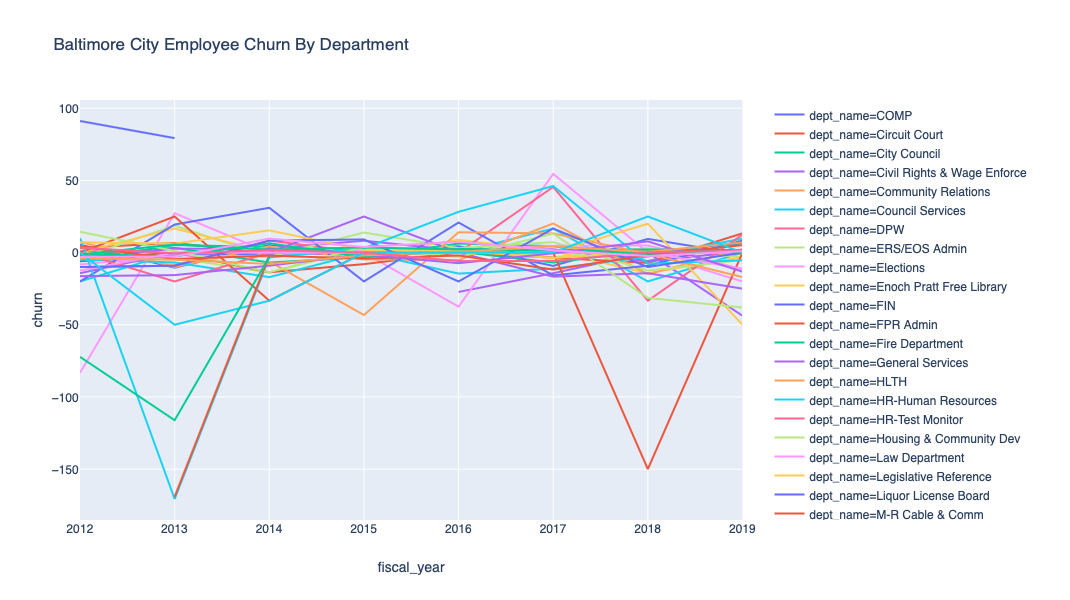

In [50]:
line_dept_churn

The sharp decreases indicate high volume hires in that fiscal year, and the sharp increases indicate high volumes of employee churn. Now we look at the top 50 highest churn rates over all of the departments in eight fiscal years, and then look at their trends over time. 

In [51]:
# sort by churn, and then keep the top 50 rows
df_top20_churn = df_dept_count.sort_values(by = "churn", ascending = False)

In [52]:
df_top20_churn = df_top20_churn.head(20)

In [53]:
# which agencies are represented in the fiscal years with highest churn
high_churn = df_top20_churn["dept_name"].unique().tolist()

In [54]:
# create a new dataframe to look at only the departments that have highest churn
df_high_churn = df_dept_count[df_dept_count["dept_name"].str.contains('|'.join(high_churn))]

In [55]:
df_high_churn.head(10)

fiscal_year         dept_name  count  lost      churn
46          2012  Council Services      6  -1.0 -20.000000
87          2013  Council Services      6  -0.0  -0.000000
128         2014  Council Services      6  -0.0  -0.000000
167         2015  Council Services      6  -0.0  -0.000000
204         2016  Council Services      6  -0.0  -0.000000
244         2017  Council Services      5   1.0  16.666667
281         2018  Council Services      6  -1.0 -20.000000
318         2019  Council Services      6  -0.0  -0.000000
49          2012         Elections     11  -5.0 -83.333333
90          2013         Elections      8   3.0  27.272727

In [56]:
# graph high churn departments only
# plot the churn of departments on a line graph
line_dept_high_churn = px.line(df_high_churn, # use revised data frame
                         x = "fiscal_year", # fiscal year on the x axis
                         y = "churn", # churn rate on the 
                          color = "dept_name",
                         title = "Baltimore City Employee Churn By Department <br> with High Churn Rates",
                          #range_y = [-20,0]
                         )

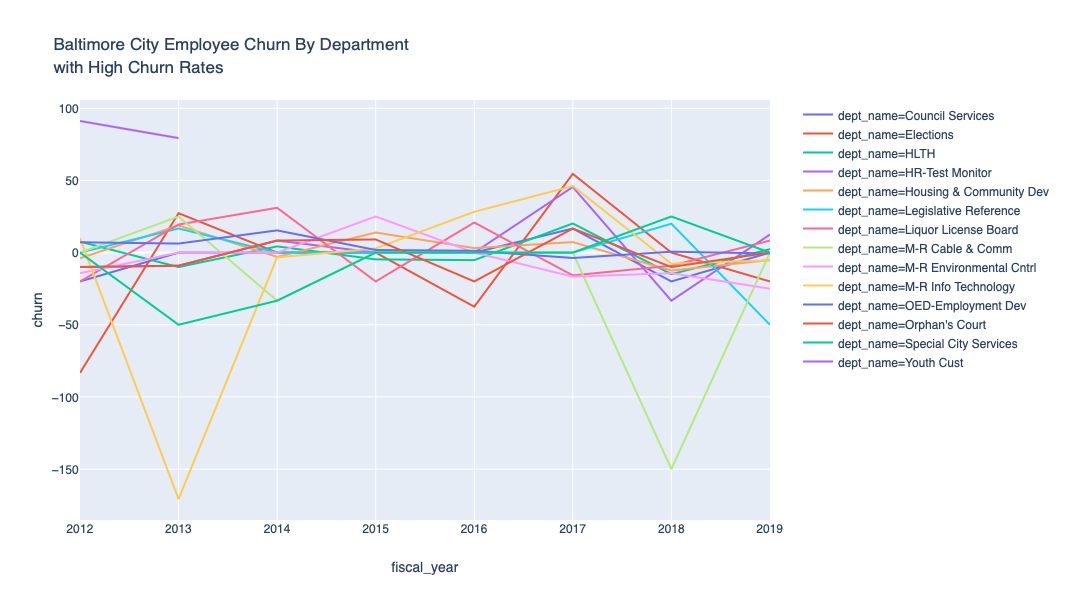

In [57]:
line_dept_high_churn

## Look at Actual Number of Employees lost and gained instead of Net Number of employees lost/gained

Each __employee_name__ is a unique identifier for the employee, so we'll use this to restructure the data and build out columns for their salary during each fiscal year. This will help us determine the number of employees lost and gained each fiscal year and how each employee's salary changed over each fiscal year. 

In [58]:
# make pivot table with employee data to keep
## gross salary of each employee
## separated in columns for each fiscal year

df_employee = pd.pivot_table(df, values = "gross", 
                             index = "employee_name", 
                             columns = "fiscal_year", 
                             aggfunc = np.sum).reset_index()

In [59]:
df_employee.head(20)

fiscal_year          employee_name      2011      2012      2013      2014  \
0                   AKROFI,BERNARD       NaN       NaN  14387.30       NaN   
1                   Aaron,Kareem D       NaN       NaN       NaN       NaN   
2                  Aaron,Keairah T       NaN       NaN      0.00       NaN   
3                  Aaron,Keontae E       NaN       NaN      0.00    873.63   
4                 Aaron,Patricia G  45505.94  52247.39  51771.01  52868.38   
5                    Aaron,Petra L  51588.89  59026.81  63909.03  67439.19   
6                    Abadir,Adam O       NaN       NaN       NaN       NaN   
7               Abaineh,Yohannes T  50633.26  57129.79  57428.85  58654.74   
8            Abaku,Aigbolosimuan O       NaN       NaN       NaN       NaN   
9                    Abbeduto,Mack       NaN       NaN       NaN       NaN   
10                Abbene,Anthony M       NaN       NaN       NaN  39686.95   
11                  Abbey,Emmanuel       NaN       NaN   3477.00  47019.75   
12                  Abbott,Ethan N       NaN       NaN       NaN       NaN   
13            Abbott-Cole,Michelle       NaN       NaN       NaN       NaN   
14              Abdal-Rahim,Naim A   3888.95  35537.88  44159.59  61451.50   
15           Abdelmeguid,Shahrazad       NaN       NaN       NaN       NaN   
16                  Abdi,Ezekiel W  51421.73  62669.25  66496.24  87900.27   
17             Abdul Adl,Attrice A       NaN  46699.58  46254.02  53667.53   
18               Abdul Aziz,Hajr E       NaN       NaN       NaN      0.00   
19             Abdul Aziz,Jennah A       NaN       NaN       NaN      0.00   

fiscal_year      2015       2016       2017       2018       2019  
0                 NaN        NaN        NaN        NaN        NaN  
1                 NaN        NaN        NaN        NaN   25743.94  
2                 NaN        NaN        NaN        NaN        NaN  
3                 NaN        NaN        NaN        NaN        NaN  
4            53626.04   54135.44   54992.37   58480.46   57806.13  
5            73000.08   72445.87   76951.93   79220.72        NaN  
6                 NaN        NaN   27736.14   57375.31   64774.11  
7            64403.84        NaN        NaN        NaN        NaN  
8                 NaN        NaN        NaN   11881.34   59361.55  
9                 NaN        NaN    2821.60   35138.40   61693.59  
10           59620.16        NaN        NaN        NaN        NaN  
11           54059.60   59602.58        NaN        NaN        NaN  
12                NaN        NaN        NaN    4642.72   26156.48  
13           20250.80   59517.21   71745.19   75011.45   75529.99  
14           83757.48   74770.82   82364.33   79114.46   82132.61  
15                NaN   16283.26   28465.60        NaN        NaN  
16           92574.91  106863.56  105836.60  112341.17  122992.10  
17           55943.29   59418.35   59045.33   62065.45   58459.78  
18            1051.25    5909.64    7233.42   13003.20   15807.64  
19            1051.25    3230.27    5252.00        NaN        NaN

In [60]:
df_employee.describe()

fiscal_year           2011           2012           2013           2014  \
count         14402.000000   15999.000000   18842.000000   18788.000000   
mean          42474.834984   43307.243956   37433.712846   38278.438664   
std           22838.054881   28477.022073   31849.706572   33392.758684   
min               7.250000     -77.000000       0.000000       0.000000   
25%           27640.110000   23879.795000    1051.250000    1051.250000   
50%           41192.665000   43231.220000   36766.495000   37146.290000   
75%           58492.937500   63662.995000   61864.122500   63611.717500   
max          170422.990000  245353.440000  238681.040000  238772.040000   

fiscal_year           2015           2016           2017           2018  \
count         13864.000000   13669.000000   13439.000000   13472.000000   
mean          55318.724987   55823.952081   55632.938317   60954.702997   
std           32685.575371   34034.213288   35232.597458   36349.131741   
min               0.000000       0.000000       0.000000       0.000000   
25%           34198.892500   33813.240000   32787.380000   37613.757500   
50%           52433.660000   52647.530000   52395.230000   57191.220000   
75%           75735.910000   75868.510000   78328.960000   81999.345000   
max          235767.920000  238295.960000  244913.700000  250197.500000   

fiscal_year           2019  
count         13626.000000  
mean          60161.151845  
std           38170.843565  
min               0.000000  
25%           35900.097500  
50%           56529.805000  
75%           82675.877500  
max          260775.260000